# 30 Days Map Challenge Day 2: Lines

his notebook is adapted from the original version by SpatialThoughts available at https://courses.spatialthoughts.com/python-dataviz.html#streamlit-basics


Datasource: https://www.hydrosheds.org/products/hydrorivers

## Setup and Data Download

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import requests
from PIL import Image, ImageDraw, ImageFont, ImageOps
from shapely.geometry import box

In [2]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [3]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)


data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/download/'

# This is a subset of the main HydroRivers dataset of all
# rivers having `UPLAND_SKM` value  greater than 100 sq. km.
hydrorivers_file = 'hydrorivers_100.gpkg'
hydrorivers_url = data_url + 'hydrosheds/'

countries_file = 'ne_10m_admin_0_countries_ind.zip'
countries_url = data_url + 'naturalearth/'


download(hydrorivers_url + hydrorivers_file)
download(countries_url + countries_file)


In [4]:
# Read countries shapefile
countries_filepath = os.path.join(data_folder, countries_file)

We can print a list of values from the `SOVEREIGNT` column of `country_gdf` GeoDataFrame using `country_gdf.SOVEREIGNT.values` to know the names of all countries.

In [5]:
# Print list of countries
country_gdf = gpd.read_file(countries_filepath)
print(sorted(country_gdf.SOVEREIGNT.unique()))

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bir Tawil', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brazilian Island', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', '

In [6]:
# Select country
country = 'Indonesia'

In [7]:
# Filter data
selected_country = country_gdf[
    (country_gdf['SOVEREIGNT'] == country) &
    (country_gdf['TYPE'] != 'Dependency')
]
selected_country

,ADM0_A3_IN,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,IDN,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


We read the river network data from HydroRivers. We specify the `mask` parameter which clips the layer to the country boundary while reading the data.

*This step can take a few minutes depending on the size of the country.*

In [8]:
hydrorivers_filepath = os.path.join(data_folder, hydrorivers_file)
river_gdf = gpd.read_file(hydrorivers_filepath, mask=selected_country)
river_gdf

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,50177043,50176641,50159820,1.77,485.8,14.9,4.08,112.9,0,6.889,3,3,6,5120157200,"MULTILINESTRING ((100.90208 -0.98125, 100.9020..."
1,50176641,50175858,50159820,3.16,482.5,18.2,7.30,125.6,0,7.648,3,3,6,5120157200,"MULTILINESTRING ((100.89375 -0.96875, 100.8895..."
2,50175858,50175737,50159820,0.46,482.0,18.7,0.43,127.9,0,7.787,3,3,6,5120157200,"MULTILINESTRING ((100.89375 -0.94375, 100.8937..."
3,50175737,50175501,50159820,1.12,480.9,19.8,3.65,184.8,0,11.297,3,3,5,5120157200,"MULTILINESTRING ((100.89375 -0.93958, 100.8979..."
4,50175501,50174874,50159820,2.70,478.4,22.3,8.37,195.1,0,11.900,3,3,5,5120157200,"MULTILINESTRING ((100.89792 -0.93125, 100.8979..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52540,50227996,50226945,50216679,3.63,70.6,30.2,9.65,202.4,0,6.618,3,1,6,5120170030,"MULTILINESTRING ((139.19375 -2.50208, 139.1979..."
52541,50228155,50227996,50216679,0.66,74.4,26.4,0.21,186.8,0,6.163,3,1,6,5120652700,"MULTILINESTRING ((139.19792 -2.50625, 139.1937..."
52542,50229115,50228155,50216679,2.97,74.9,26.0,6.22,170.1,0,5.640,3,1,6,5120652700,"MULTILINESTRING ((139.19375 -2.53125, 139.1979..."
52543,50229275,50229115,50216679,0.66,78.0,22.8,2.36,157.0,0,5.224,3,1,6,5120652700,"MULTILINESTRING ((139.18958 -2.53542, 139.1937..."


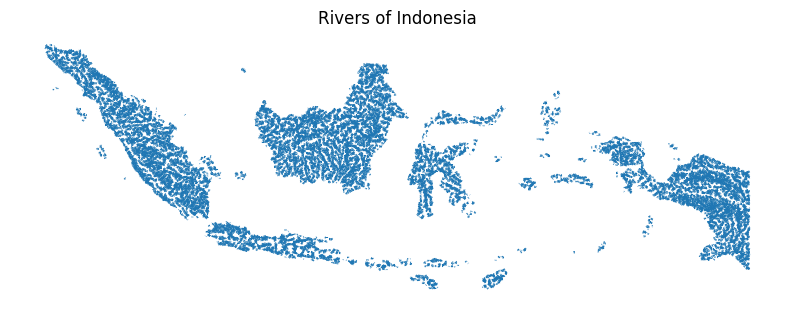

In [9]:
# Viz
fig, ax = plt.subplots(figsize=(10, 10))
title = f'Rivers of {country}'
river_gdf.plot(ax=ax)
ax.set_title(title)
ax.set_axis_off()
plt.show()

In [10]:
# Define the bounding box for Kalimantan
minx, miny, maxx, maxy = 108.5, -4.5, 118.825, 4.5
bounding_box = gpd.GeoDataFrame(
    {'geometry': [box(minx, miny, maxx, maxy)]},
    crs="EPSG:4326"  # Ensure the CRS matches your river data
)

In [11]:
# Clip rivers to Kalimantan Island's boundary
if river_gdf.crs != bounding_box.crs:
    river_gdf = river_gdf.to_crs(bounding_box.crs)

kalimantan_rivers = gpd.clip(river_gdf, bounding_box)

<Axes: >

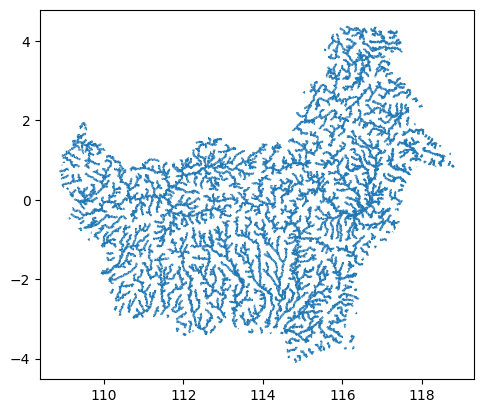

In [12]:
# Visualize
kalimantan_rivers.plot()

# Final Visualization

We want to style the rivers so that the width of the line is proportional to the value in the `UPLAND_SKM` attribute. We add a new column `width` to the GeoDataFrame by scaling the input values to a range of target widths.

*Tip: These values will play an important role in your final visualization. Adjust these to suit the range of values for your country.*

In [13]:
original_min = 300
original_max = 10000
target_min = 0.8
target_max = 4
scaled = (kalimantan_rivers['UPLAND_SKM'] - original_min) / (original_max - original_min)
kalimantan_rivers['width'] = scaled.clip(0, 1) * (target_max - target_min) + target_min
kalimantan_rivers_final = kalimantan_rivers.sort_values(['UPLAND_SKM', 'width'])[['MAIN_RIV', 'UPLAND_SKM', 'width', 'geometry']]
kalimantan_rivers_final

,MAIN_RIV,UPLAND_SKM,width,geometry
24625,50261828,100.1,0.8,"LINESTRING (114.83125 -3.13958, 114.81875 -3.1..."
18632,50251134,100.1,0.8,"LINESTRING (112.02292 -3.23125, 112.02292 -3.2..."
22584,50246777,100.2,0.8,"LINESTRING (113.18958 -2.14375, 113.18542 -2.1..."
33088,50244101,100.2,0.8,"LINESTRING (111.76875 -1.94792, 111.76458 -1.9..."
19045,50244101,100.2,0.8,"LINESTRING (111.26458 -1.51875, 111.26875 -1.5..."
...,...,...,...,...
11822,50154408,83498.8,4.0,"LINESTRING (109.25208 -0.26458, 109.24792 -0.2..."
11823,50154408,83510.1,4.0,"LINESTRING (109.24792 -0.26042, 109.24375 -0.2..."
11824,50154408,83525.8,4.0,"LINESTRING (109.23958 -0.25625, 109.22708 -0.2..."
11825,50154408,83592.8,4.0,"LINESTRING (109.22708 -0.24375, 109.22292 -0.2..."


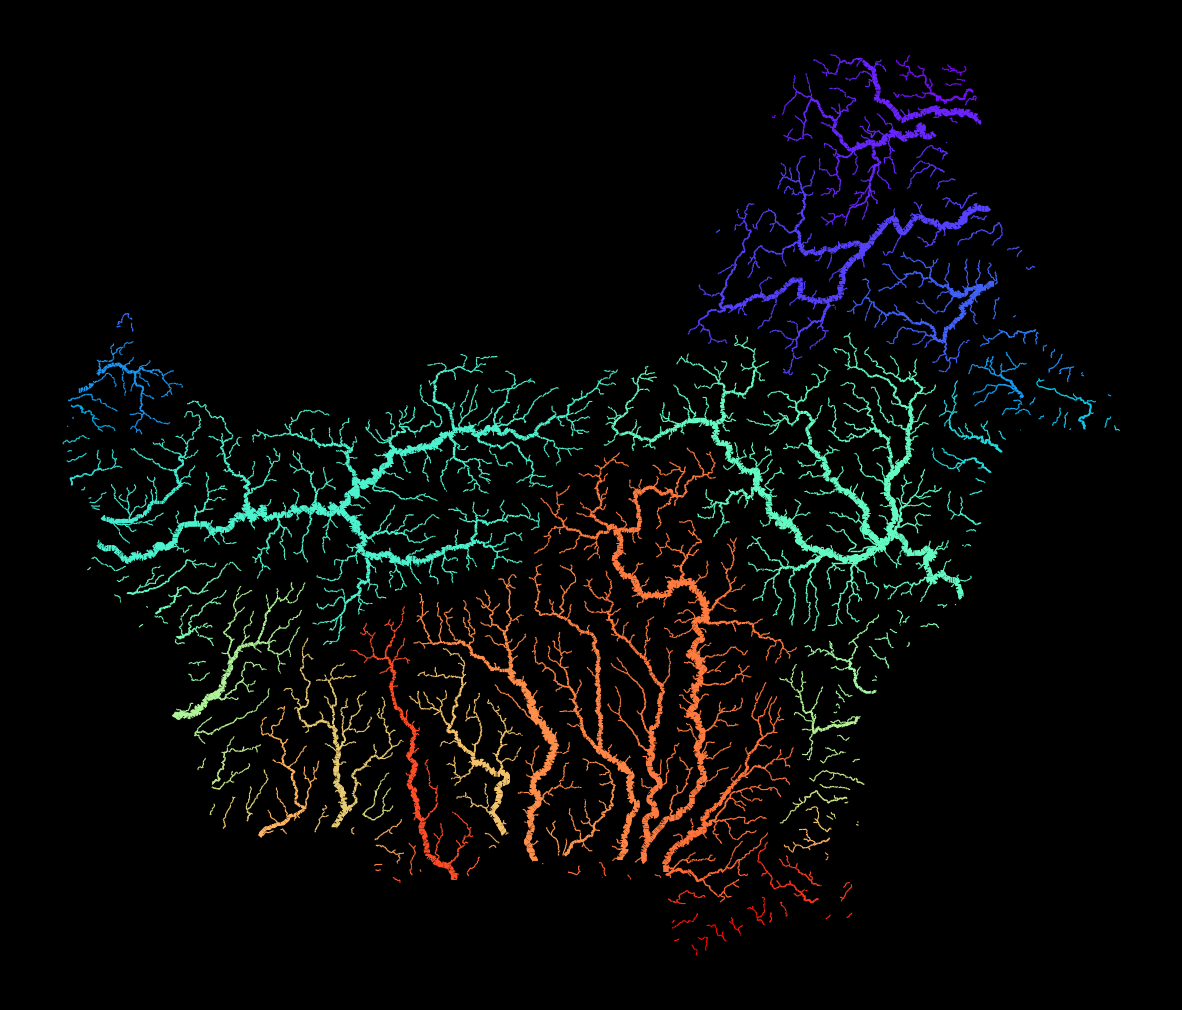

In [14]:
# Plot the river network
fig, ax = plt.subplots(figsize=(15, 15), facecolor='black')

kalimantan_rivers_final.plot(
    ax=ax,
    column='MAIN_RIV',
    linewidth=kalimantan_rivers_final['width'],
    cmap='rainbow',
    categorical=True
)

ax.axis('off')
plt.savefig("kalimantan_river_network.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


In [15]:
# Download the fonts
title_font_url = "https://github.com/google/fonts/raw/main/ofl/merriweather/Merriweather-Regular.ttf"
footer_font_url = "https://github.com/google/fonts/raw/main/ofl/lato/Lato-Regular.ttf"
title_font_path = "TitleFont-Regular.ttf"
footer_font_path = "FooterFont-Regular.ttf"

# Download Title Font
with open(title_font_path, "wb") as file:
    file.write(requests.get(title_font_url).content)

# Download Footer Font
with open(footer_font_path, "wb") as file:
    file.write(requests.get(footer_font_url).content)

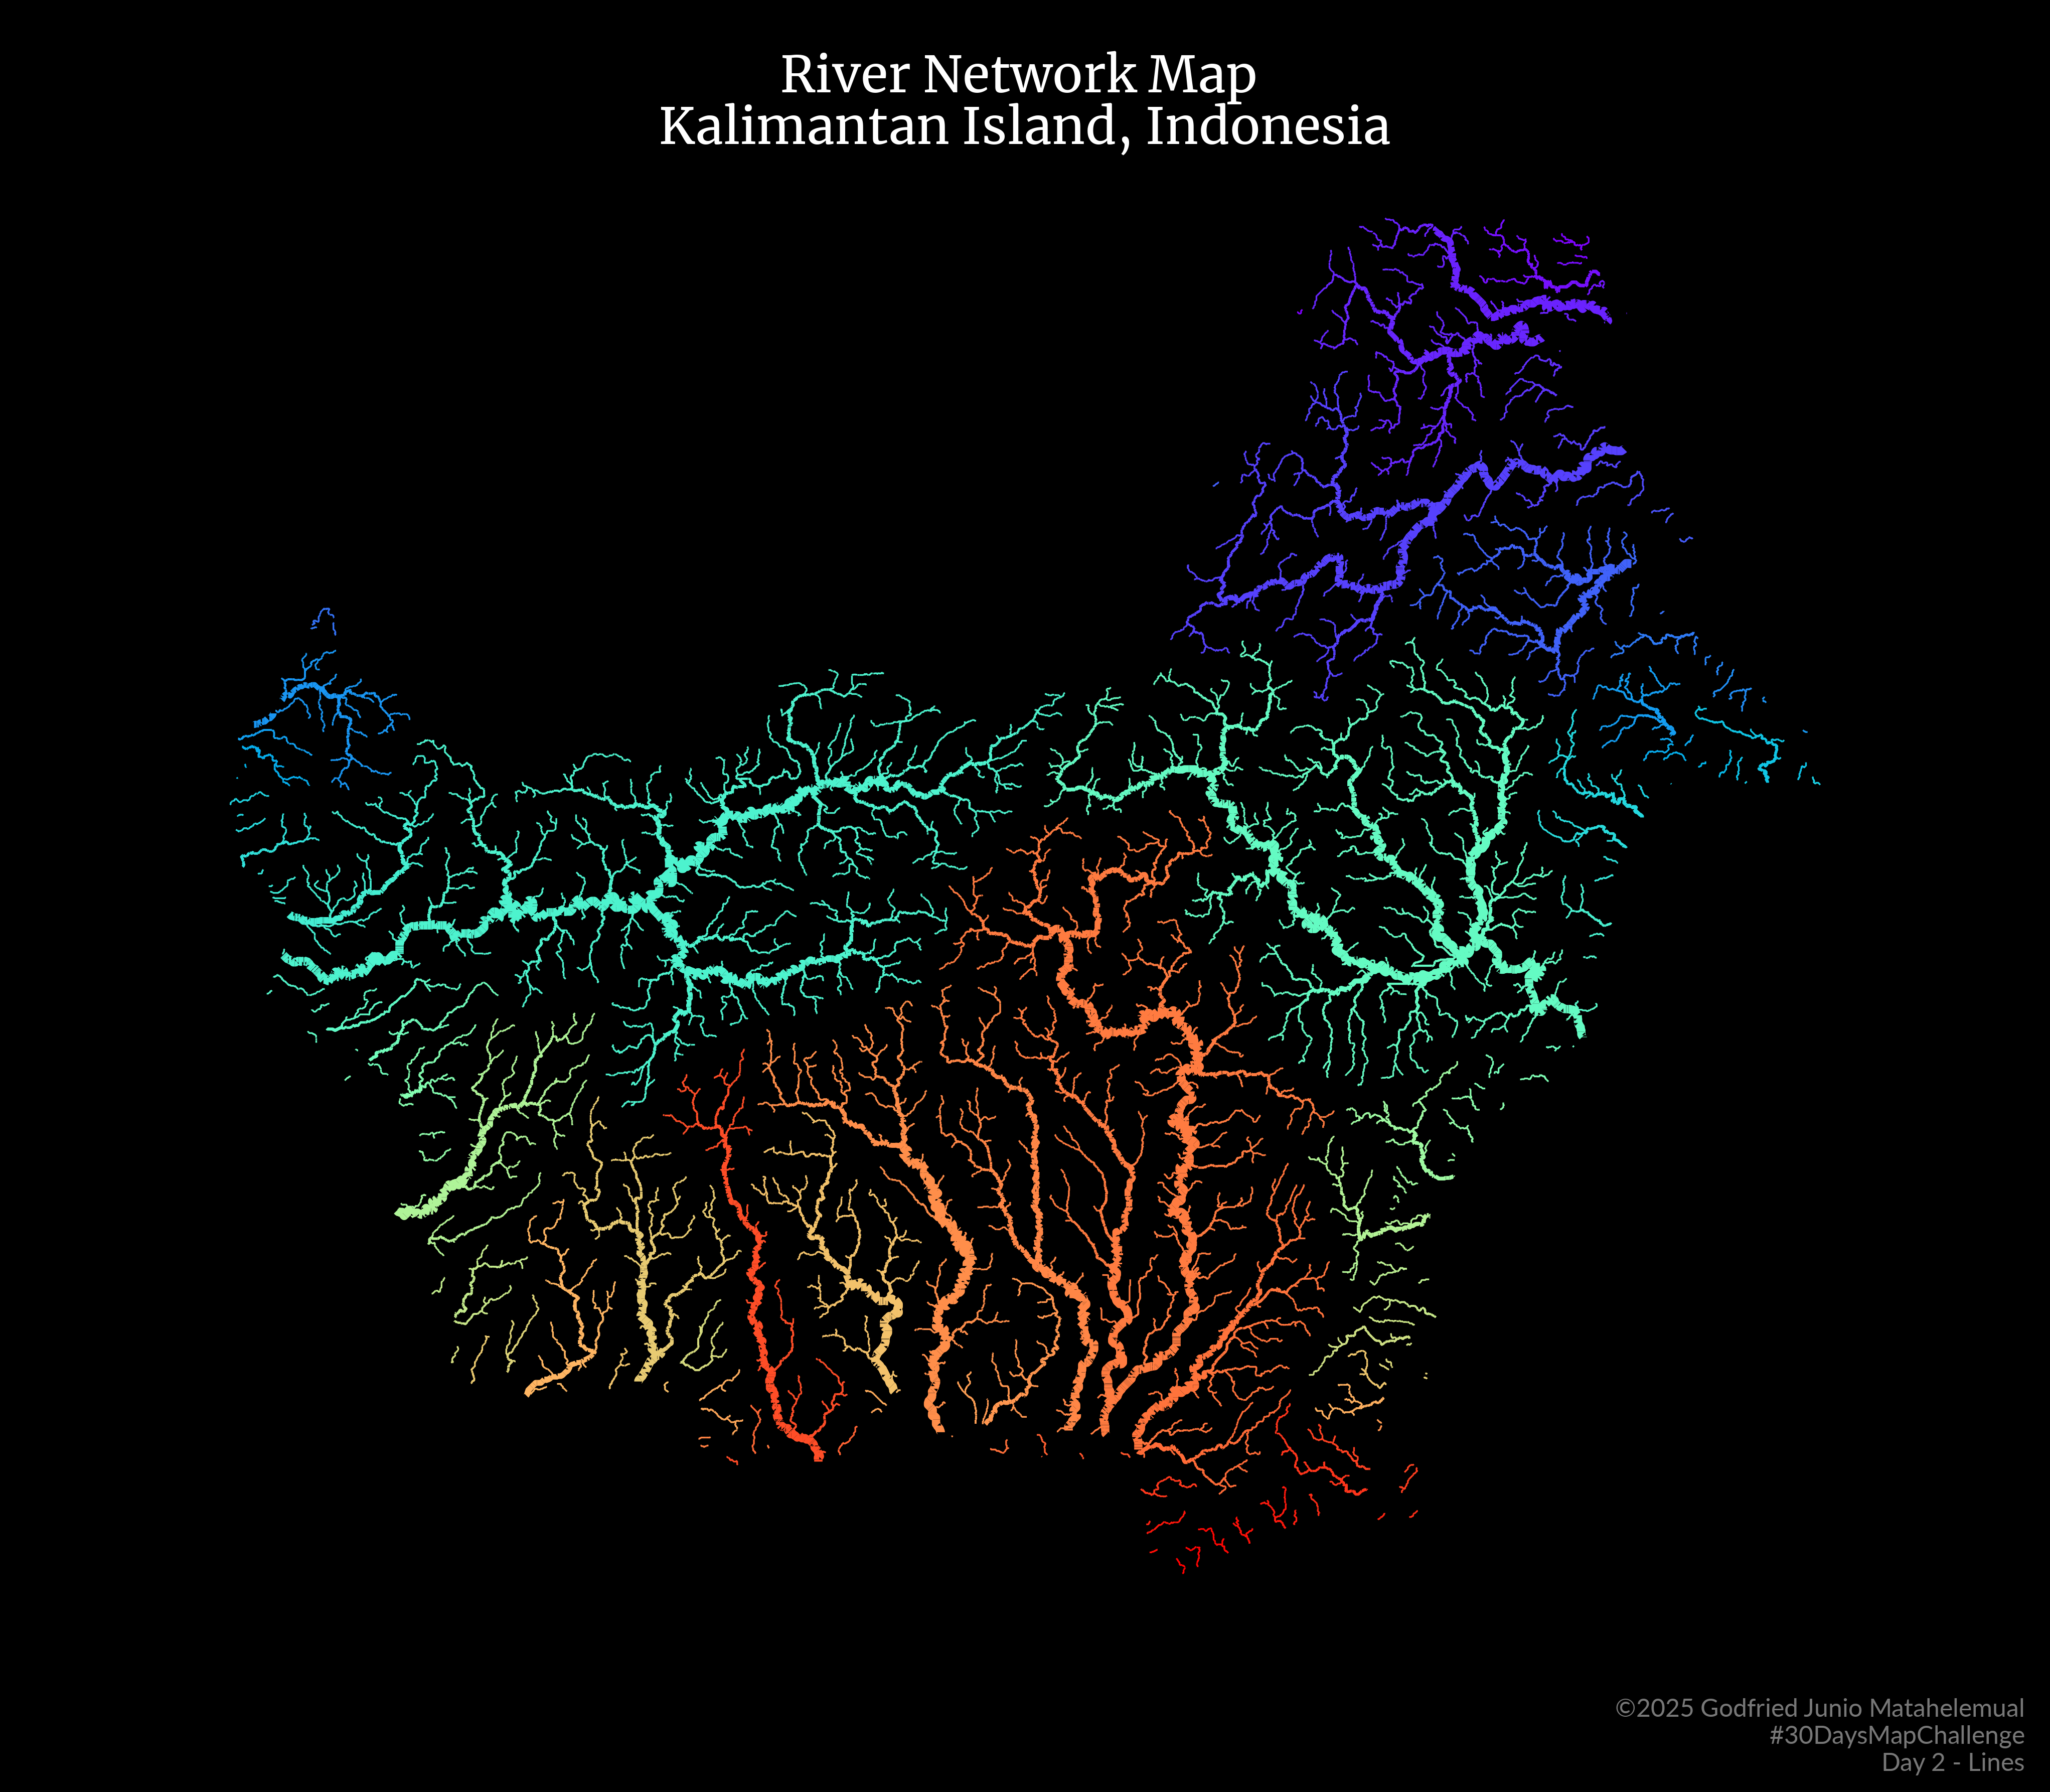

In [16]:
# Load the exported map image
map_image = Image.open("kalimantan_river_network.png")

# Add padding to the image
padding = (300, 300, 300, 300)  # (left, top, right, bottom)
padded_image = ImageOps.expand(map_image, border=padding, fill="black")

# Create a drawing context
draw = ImageDraw.Draw(padded_image)

# Load fonts
title_font = ImageFont.truetype(title_font_path, size=100)
footer_font = ImageFont.truetype(footer_font_path, size=50)

# Add title
title_text = "River Network Map \nKalimantan Island, Indonesia"
title_position = (padded_image.width // 2, 200)  # Centered in the top padding
draw.multiline_text(
    title_position,
    title_text,
    font=title_font,
    fill="white",
    anchor="mm",
    align="center",
)

# Add footer
footer_text = "©2025 Godfried Junio Matahelemual\n#30DaysMapChallenge\nDay 2 - Lines"
footer_position = (padded_image.width - 50, padded_image.height - 200)
draw.multiline_text(
    footer_position,
    footer_text,
    font=footer_font,
    fill="#777777",  # Light gray
    anchor="ra",  # Right-aligned
    align="right",
)

# Save the final annotated image
output_filename = "finalmap_kalimantan_river_network_annotated.png"
padded_image.save(output_filename)

# Display result
padded_image
